<a href="https://colab.research.google.com/github/sawadogosalif/A_journey_in_Machine_Learning/blob/main/03_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
require(caret)  #for easy machine learning workflow
require(MASS)   #for Modern Applied Statistic
require(dplyr)    # alternatively, this also loads %>%
library(rpart) # (Reursive PARTitioning) 
library(rpart.plot)
library(visNetwork) #customize tree
library(ggparty)
library(readxl)
library(party)

In [ ]:
install.packages('party')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘TH.data’, ‘matrixStats’, ‘multcomp’, ‘modeltools’, ‘strucchange’, ‘coin’, ‘zoo’, ‘sandwich’




# FUNCTIONS

1. **Accuracy for Multiclassification**

In [ ]:
### OVERALL ACCURACY
calculate.accuracy <- function(predictions, ref.labels) {
  return(length(which(predictions == ref.labels)) / length(ref.labels))
}

### OVERALL WEIGHT ACCURACY

calculate.w.accuracy <- function(predictions, ref.labels, weights) {
  lvls <- levels(ref.labels)
  if (length(weights) != length(lvls)) {
    stop("Number of weights should agree with the number of classes.")
  }
  if (sum(weights) != 1) {
    stop("Weights do not sum to 1")
  }
  accs <- lapply(lvls, function(x) {
    idx <- which(ref.labels == x)
    return(calculate.accuracy(predictions[idx], ref.labels[idx]))
  })
  acc <- mean(unlist(accs))
  return(acc)
}

## FUNCTIONS TO CUSTOMIZE the 2 previous functions

accuracy_rate<-function (prediction, cluster)
{
  acc <- calculate.accuracy(factor(prediction),factor(cluster))
  print(paste0("Accuracy is: ", round(acc, 2)))
  
  weights <- rep(1 / length(levels(cluster)), length(levels(cluster)))
  w.acc <- calculate.w.accuracy(factor(prediction), factor(cluster), weights)
  
  print(paste0("Weighted accuracy is: ", round(w.acc, 2)))
  
}     

2. **F1 for Multiclassification**

In [ ]:

##CONFUSION MATRIX FOR MULTICLASSIFICATION

get.conf.stats <- function(cm) {
  out <- vector("list", length(cm))
  for (i in seq_along(cm)) {
    x <- cm[[i]]
    tp <- x$table[x$positive, x$positive] 
    fp <- sum(x$table[x$positive, colnames(x$table) != x$positive])
    fn <- sum(x$table[colnames(x$table) != x$positie, x$positive])
    # TNs are not well-defined for one-vs-all approach
    elem <- c(tp = tp, fp = fp, fn = fn)
    out[[i]] <- elem
  }
  df <- do.call(rbind, out)
  rownames(df) <- unlist(lapply(cm, function(x) x$positive))
  return(as.data.frame(df))
}



##Compute F1
###Micro F1
get.micro.f1 <- function(cm) {
  cm.summary <- get.conf.stats(cm)
  tp <- sum(cm.summary$tp)
  fn <- sum(cm.summary$fn)
  fp <- sum(cm.summary$fp)
  pr <- tp / (tp + fp)
  re <- tp / (tp + fn)
  f1 <- 2 * ((pr * re) / (pr + re))
  return(f1)
}

###Macro F1
get.macro.f1 <- function(cm) {
  c <- cm[[1]]$byClass # a single matrix is sufficient
  re <- sum(c[, "Recall"]) / nrow(c)
  pr <- sum(c[, "Precision"]) / nrow(c)
  f1 <- 2 * ((re * pr) / (re + pr))
  return(f1)
}

library(caret)


#CUSTOMIZE micro F1 and macro F1
F1_rate<-function(prediction, cluster)


{
  cm <- vector("list", length(levels(factor(cluster))))
  for (i in seq_along(cm)) {
    positive.class <- levels(cluster)[i]
    # in the i-th iteration, use the i-th class as the positive class
    cm[[i]] <- confusionMatrix(factor(prediction), factor(cluster), 
                               positive = positive.class)
   }
  
  macro.f1 <- get.macro.f1(cm)
  micro.f1 <- get.micro.f1(cm)
  
  print(paste0("Macro F1 is: ", round(macro.f1, 2)))
  print(paste0("Micro F1 is: ", round(micro.f1, 2)))
  


}

3. **Plot CTREE with ggplot**

In [ ]:
plot_ctree<-function(model.ctree){
ggparty(model.ctree) +
  geom_edge() +
  geom_edge_label(mapping = aes(label = substr(breaks_label, start = 1, stop = 15)))+
  geom_node_label(
    line_list = list(
      aes(label = splitvar),
      aes(label = paste("N =", nodesize))
    ),
    line_gpar = list(
      list(size = 13),
      list(size = 10)
    ),
    ids = "inner"
  ) +
  geom_node_label(aes(label = paste0("Node ", id, ", N = ", nodesize)),
                  ids = "terminal", nudge_y = -0.3, nudge_x = 0.01
  ) +
  geom_node_plot(
    gglist = list(
      geom_bar(aes(x = "", fill = cluster),
               position = position_fill(), color = "black"
      ),
      theme_minimal(),
      scale_fill_manual(values = c("brown1","goldenrod", "forestgreen", "turquoise3","steelblue2","hotpink"), guide = FALSE),
      scale_y_continuous(breaks = c(0, 1)),
      xlab(""), ylab("proportion declined"),
      geom_text(aes(
        x = "", group = cluster,
        label = stat(count)
      ),
      stat = "count", position = position_fill(), vjust = 1.7
      )
    ),
    shared_axis_labels = TRUE
  )
}

# Data

In [ ]:
data=read_excel("/content/output_tp1.xlsx")


data$cluster=factor(data$cluster)
set.seed(123)
train.size=0.8
train.index<- sample.int(dim(data)[1],round(dim(data)[1] * train.size ))
train.sample=data[train.index, ]
test.sample=data[-train.index, ]

# CART

## Deep tree

In [ ]:
# Arbre profond
cart1 = rpart(cluster~ . ,
              data = train.sample,
              method="class",
              parms=list(split="gini"),
              cp=0)
              # By default :rpart.control(minsplit = 20, minbucket = round(minsplit/3),

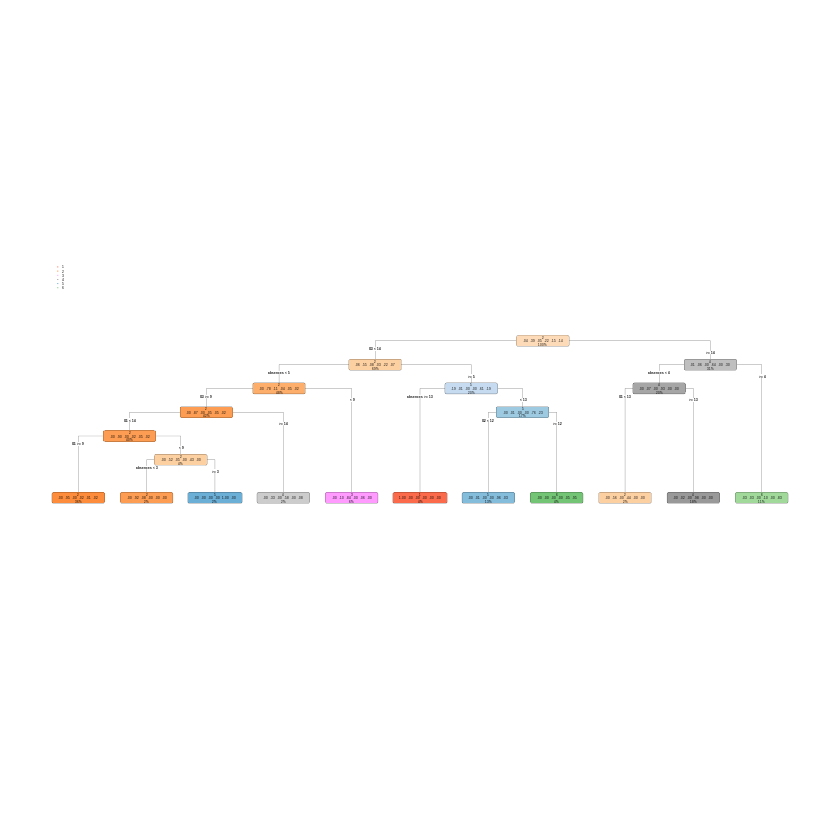

In [ ]:
rpart.plot(cart1,type = 4) 

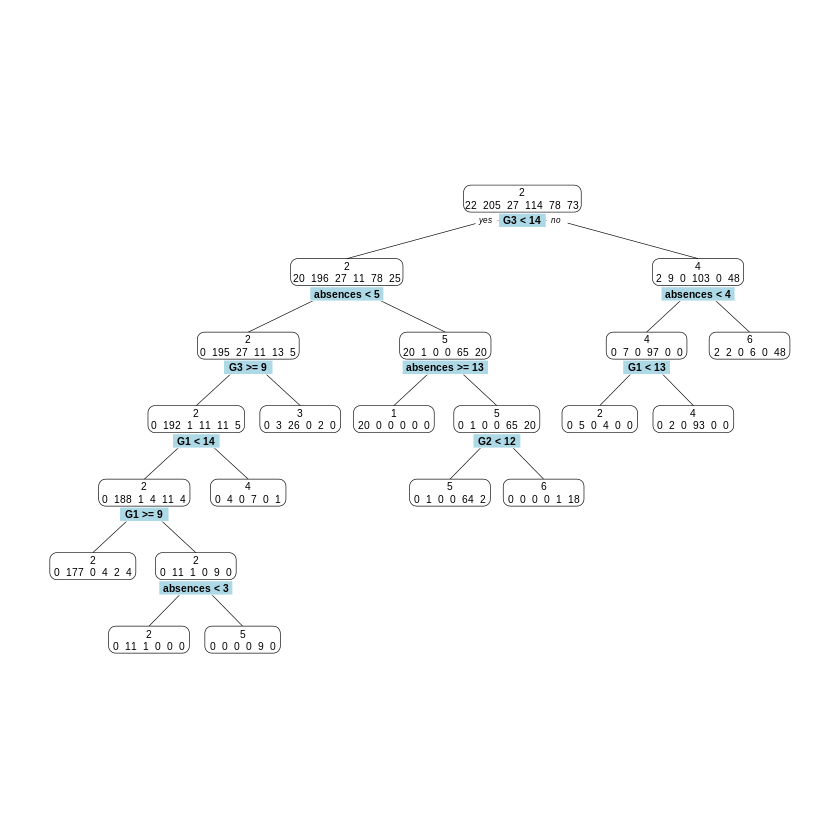

In [ ]:
prp(cart1,type=2,extra=1,split.box.col="lightblue")

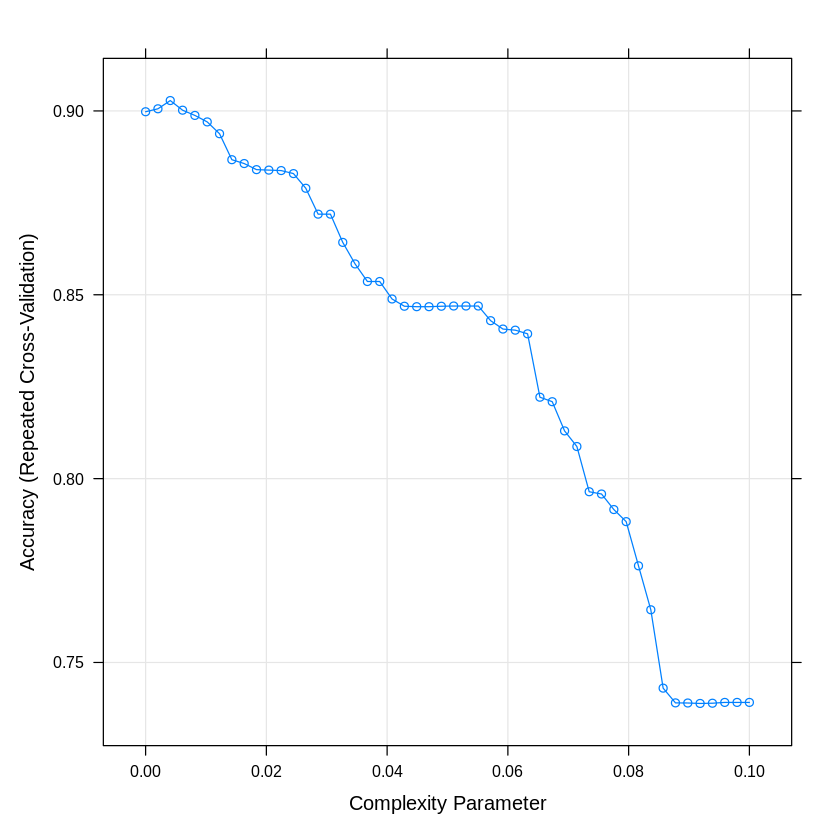

In [ ]:
cv.cart <- train(cluster~.,data=data,method="rpart",
                 metric="Accuracy",
                 trControl=trainControl(method="repeatedcv",
                                        repeats=50,
                                        number=10),
                 tuneGrid=data.frame(cp=seq(0,0.1,length=50)))

plot(cv.cart)

## Best fit

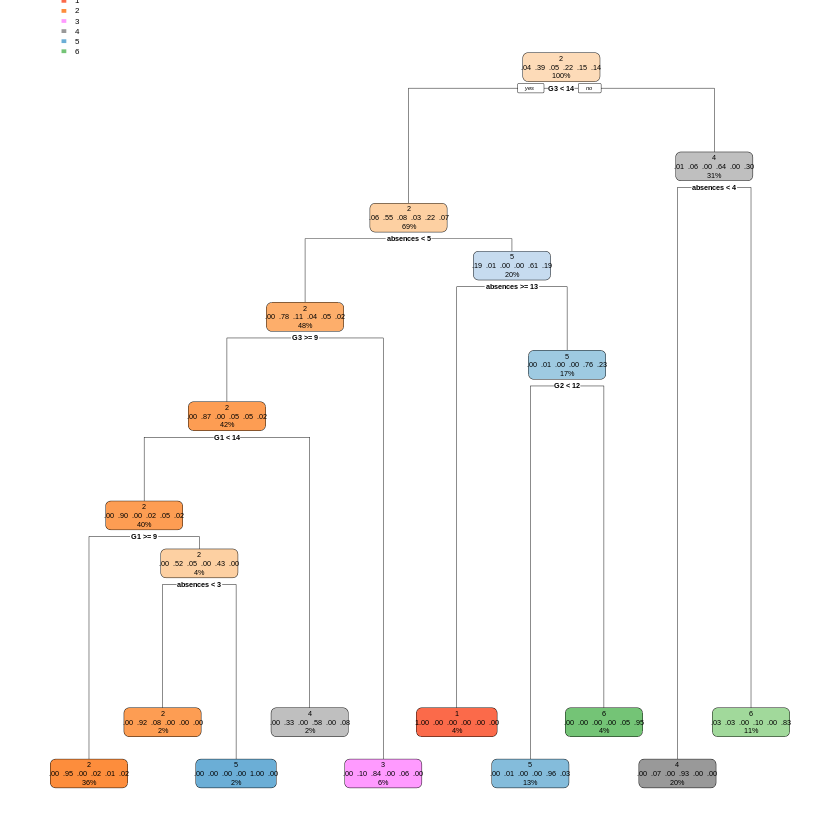

In [ ]:
model.cart <- prune(cart1,cp=as.numeric(cv.cart$best))
rpart.plot(model.cart)

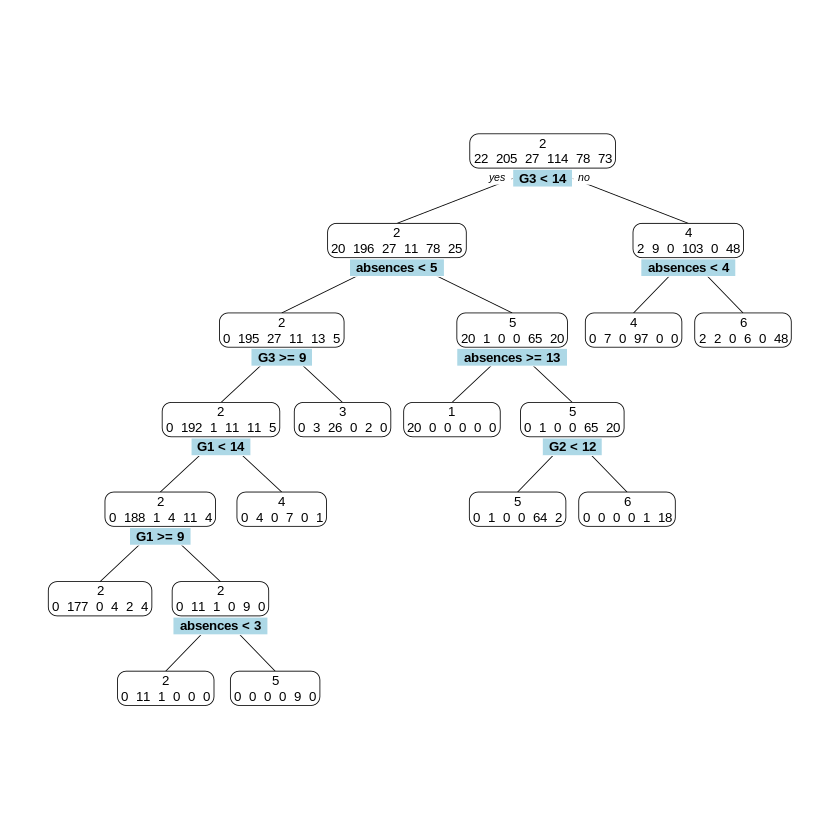

In [ ]:
prp(model.cart,type=2,extra=1,split.box.col="lightblue")

## Model assessment

In [ ]:
## cart prediction
pred.cart_train <- predict(model.cart,train.sample,type="class")
pred.cart_test  <- predict(model.cart,test.sample,type="class")

Les performances sur le Train Set

In [ ]:
accuracy_rate(pred.cart_train,  train.sample$cluster)

[1] "Accuracy is: 0.92"
[1] "Weighted accuracy is: 0.92"


In [ ]:
F1_rate(pred.cart_train,   train.sample$cluster)

[1] "Macro F1 is: 0.92"
[1] "Micro F1 is: 0.96"


Les performances sur le Test Set

In [ ]:
accuracy_rate(pred.cart_test,   test.sample$cluster)

[1] "Accuracy is: 0.84"
[1] "Weighted accuracy is: 0.82"


In [ ]:
F1_rate(pred.cart_test,   test.sample$cluster)

[1] "Macro F1 is: 0.84"
[1] "Micro F1 is: 0.91"


En comparant les performances du test set et celui du train set, il semble avoir overfitting

# CTREE

## Fit

In [ ]:
library(partykit)
model.ctree= ctree(cluster ~., data = train.sample,  control=ctree_control(mincriterion =0.95, minbucket=10,
 testtype = "Bonferroni"))

## How to evaluate the model?


In [ ]:
pred.ctree_train <- predict(model.ctree,train.sample)
pred.ctree_test  <- predict(model.ctree,test.sample)

[1] "Accuracy is: 0.9"
[1] "Weighted accuracy is: 0.91"
[1] "Accuracy is: 0.86"
[1] "Weighted accuracy is: 0.83"
[1] "Macro F1 is: 0.91"
[1] "Micro F1 is: 0.95"
[1] "Macro F1 is: 0.86"
[1] "Micro F1 is: 0.93"


Train set

In [ ]:
accuracy_rate(pred.ctree_train,  train.sample$cluster)
F1_rate(pred.ctree_train,   train.sample$cluster)

[1] "Accuracy is: 0.9"
[1] "Weighted accuracy is: 0.91"
[1] "Macro F1 is: 0.91"
[1] "Micro F1 is: 0.95"


Test Set

In [ ]:
accuracy_rate(pred.ctree_test,   test.sample$cluster)
F1_rate(pred.ctree_test,   test.sample$cluster)

[1] "Accuracy is: 0.86"
[1] "Weighted accuracy is: 0.83"
[1] "Macro F1 is: 0.86"
[1] "Micro F1 is: 0.93"


In [ ]:
ggparty(model.ctree)

ERROR: ignored

Ce model d'arbre semble moins subir l'effet de surapprentissage.

In [ ]:
# Check needed packages 

reqPks <- c("tidyverse","partykit","data.tree","igraph","caret","ggpubr","ggridges")

missPks <- reqPks[!(reqPks %in% installed.packages()[,"Package"])]

if(length(missPks)) install.packages(missPks)


# Functions to plot a regression tree with ggplot2

get_node_splits <- function(fit, node) { 
  
  d <- depth(fit)
  
  
  if(is.terminal(node_party(fit[node]))) {
    
    data.frame(node = node,
               name = NA,
               levels = NA,
               depth = d,
               split = NA)
    
  } else {
    
    data.frame(node = node,
               character_split(split_node(node_party(fit[node])),data = data_party(fit)),
               depth = d - depth(fit[node]),
               split = c(1,2))
    
  }
}


base_breaks_x <- function(x){
  b <- pretty(x)
  d <- data.frame(y=-Inf, yend=-Inf, x=min(b), xend=max(b))
  list(geom_segment(data=d, aes(x=x, y=y, xend=xend, yend=yend), inherit.aes=FALSE),
       scale_x_continuous(breaks=b))
}


ggCtreeReg <- function(fit, type = c("wisker","ridges"), 
                       xlabel = NULL, vline = NULL, ridges_bandwidth = NULL,
                       labels_fill = "gray90",ridges_fill = alpha("blue",0.5),labels_colour = "black") {
  
  require(tidyverse)
  require(partykit)
  require(data.tree)
  require(igraph)
  require(caret)
  require(ggridges)
  require(ggpubr)
  
  # Error check #################################
  
  if(!(any(class(fit) %in% c("constparty","party")))) stop("fit object class is not constparty or party")
  if(!is.numeric(data_party(fit)[,as.character(formula(fit)[[2]])])) stop("Reponse variable is not numeric")
  if(!(type[1] %in% c("wisker","ridges"))) stop("type should be 'wisker' or 'ridges")
  
  # Get data out of fit object #################
  
  # Get nodes
  nodes <- suppressWarnings(data.frame(node = nodeids(fit)) %>%
                              rowwise() %>% 
                              do(x = get_node_splits(fit,.$node)) %>%
                              unnest()) 
  
  # Predictions for nodes
  nodes_pred <- data.frame(node = predict(fit, type = "node"),
                           pred = round(predict(fit),2)) %>%
    bind_cols(as.data.frame(predict(fit, type = "q"))) %>%
    unique() %>%
    arrange(node) %>%
    mutate(n = as.vector(table(predict(fit, type = "node")))) %>%
    bind_rows(data.frame(node = nodes$node[!is.na(nodes$name)])) %>%
    mutate(node = factor(node, max(nodes$node):1))
  
  # Get original data for ridges
  nodes_data<- data_party(fit)[,c("(fitted)","(response)")] %>%
    transmute(y = `(response)`, node = `(fitted)`) %>%
    bind_rows(data.frame(y = NA, node = nodes$node[!is.na(nodes$name)])) %>%
    mutate(node = factor(node, max(nodes$node):1))
  
  
  #  Get paths
  path <- as.data.frame(get.edgelist(as.igraph.Node(as.Node(fit)))) %>%
    `names<-`(c("node_from","node_to")) %>%
    mutate_all(function(x) as.numeric(as.character(x))) %>%
    mutate(split = rep(1:2,length(node_from)/2))
  
  path <- path %>%
    left_join(nodes %>% transmute(node, depth_from = depth),
              by = c("node_from" = "node")) %>%
    left_join(path %>%
                left_join(nodes %>% transmute(node, depth_to = depth),
                          by = c("node_to" = "node"))) %>%
    mutate(depth_from = depth_from) %>%
    left_join(path %>%
                left_join(nodes %>% transmute(node, depth_from = depth, levels, split),
                          by = c("node_from" = "node",
                                 "split" = "split"))) %>%
    unique()
  
  
  # Plot the regression tree ##################
  
  # Ajustment factor for plot
  xadj <- max(nodes$depth)
  
  # Look for xlabel
  if(is.null(xlabel))  xlabel <- as.character(formula(fit)[[2]])
  
  
  # Theme for plotting
  
  basetheme <-  theme_gray()+
    theme(axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          panel.background = element_rect(fill = "white"),
          panel.grid.major.y = element_blank(),
          panel.grid.minor.y = element_blank(),
          plot.margin = unit(c(0,0,2,0),"mm"),
          axis.title.y = element_blank(),
          legend.position = "none")
  
  # Re-scaled node prediction data
  #nodes_pred_scaled <- data.frame(lapply(nodes_pred[,2:5],function(x)(x - xlims[1])/(xlims[2] - xlims[1])), node = nodes_pred$node,                                  n = nodes_pred$n)
  
  #Base plot
  p1 <- ggplot(data = path) +
    # Elbow connector
    geom_segment(aes(y = node_from + xadj/30 ,
                     yend = node_to, 
                     x = depth_from + xadj/30, 
                     xend = depth_from + xadj/30)) + 
    geom_segment(aes(y = node_to,
                     yend = node_to, 
                     x = depth_from + xadj/30 ,
                     xend = depth_to),
                 arrow = arrow(ends = "last", length = unit(0.1, "inches"), type = "closed")) + 
    geom_label(aes(x = depth, y = node, label = gsub("_"," ",name)),
               data = nodes %>% left_join(nodes_pred %>%
                                            mutate(node = as.numeric(as.character(node)))),
               label.size = 0.5, hjust = 0, size = 5, fill = labels_fill,
               colour = labels_colour) + 
    geom_label(aes(y = node_to, x = depth_from + 0.25, label = levels), fill = "white", 
               label.size =0,hjust = 0, size = 3) + 
    xlab(" ") +
    scale_y_reverse(breaks = 1:max(nodes$node),name = "Node") 
  
  
  # Add Annoation with fit statistics
  a <- defaultSummary(data.frame(obs = data_party(fit)[,as.character(formula(fit)[[2]])],
                                 pred = predict(fit,newdata = data_party(fit))))
  
  stat_lab <- paste0("r^2 ==",round(a[2],2),"~~~MAE==",round(a[3],1),"~~~RMSE==",round(a[1],1))
  
  p1 <- p1 +
    annotate("text",y= max(nodes$node) - 1,x=0, label = "Tree fit statistics:", hjust = 0, size = 5) + 
    annotate("text",y= max(nodes$node) - 0,x=0, label = stat_lab, parse = T, hjust = 0)
  
  # Add theme 
  p1 <- p1 + 
    basetheme + 
    theme(axis.text.x = element_text(colour = "white"),
          axis.ticks.x = element_line(colour = "white"))
  
  
  # Add plot of data 
  
  if(type[1] == "ridges"){
    
    p2 <- nodes_data %>%
      ggplot(aes(y, factor(node))) +
      stat_density_ridges(geom = "density_ridges_gradient",
                          fill = ridges_fill,
                          quantile_lines = TRUE, scale = 0.8,
                          bandwidth = ridges_bandwidth, 
                          size = 0.5,calc_ecdf = TRUE, quantiles = c(0.05,0.5,0.95)) +
      geom_text(aes(x = pred, label = paste("n =",n)), 
                fontface = "italic",  size = 2.5,
                position = position_nudge(y=-0.25),
                data = nodes_pred) +
      geom_point(aes(x = pred), data = nodes_pred, size = 2, position = position_nudge(y=0)) + 
      labs(y="", x = xlabel) +
      basetheme + 
      base_breaks_x(nodes_data$y)
    
  }
  
  if(type[1] == "wisker"){
    
    p2 <- nodes_pred %>%
      ggplot(aes(y=node)) +
      geom_errorbarh(aes(y = node, xmin =`10%`, xmax = `90%`)) +
      geom_point(aes(x = pred), fill = "red", shape = 21, size = 4) + 
      geom_text(aes(x =`90%`, label = paste("  n =",n)), 
                fontface = "italic",  size = 2.5, hjust = 0,
                data = nodes_pred) +
      labs(y="", x = xlabel) +
      theme(axis.title.y = element_blank()) + 
      basetheme + 
      base_breaks_x(nodes_data$y)
    
  }
  
  if(!is.null(vline)) p2 <- p2 + geom_vline(xintercept = vline, linetype = 3)
  
  # Return 
  return(ggarrange(p1,p2, widths = c(0.7,0.3)))
} 

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘RcppArmadillo’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’




In [ ]:
ggCtreeReg(model.ctree) 

In [ ]:

















# affichage avec package rpart.plot
# plotting
plot_ctree(model.ctree)
prp(model.cart,type=2,extra=1,split.box.col="lightgray")






#===============================================================================


#######C50


#Elagagee :a l'effectif du noeud
#C5.0 cherche `a minimiser l'entropie dans les noeuds-fils
#C5.0 n'est pas binaire. �

library(C50)
library(mlbench)
#---cubist
c50_grd<-expand.grid(
  .winnow = c(TRUE, FALSE),
  .trials=1:15,
  .model="tree"
)
set.seed(849)

#winnow	A logical: should predictor winnowing (i.e feature selection) be used?


rctrl_repcv=trainControl(method = "cv",
                         number = 10,
                         repeats = 10, 
                         returnResamp="all")


c50_cv <- train(cluster ~ .,
                data = train.sample,
                method = "C5.0",
                na.action = na.pass,
                trControl = trainControl(method = "cv", number = 10),
                tuneGrid = c50_grd,
                verbose=FALSE)




model.c50<- C5.0(cluster ~ .,
                 data = train.sample,
                 trials=1,
                 control= C5.0Control(winnow = FALSE, minCases = 15))
#Trial =6
#nO Winnowing

## cart prediction
pred.c50_train <- predict(model.c50,train.sample)
pred.c50_test  <- predict(model.c50,test.sample)

##accuracy_rate(pred.cart_test,test.sample$cluster)

accuracy_rate(pred.c50_train,  train.sample$cluster)
accuracy_rate(pred.c50_test,   test.sample$cluster)

F1_rate(pred.c50_train,   train.sample$cluster)
F1_rate(pred.c50_test,   test.sample$cluster)

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'C:/Users/u32118508/OneDrive - UPEC/Bureau/scoring/00_functions_multiclass.R': No such file or directory”


ERROR: ignored